<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:07:01] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


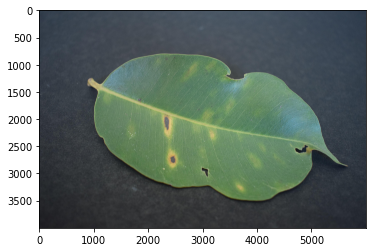

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

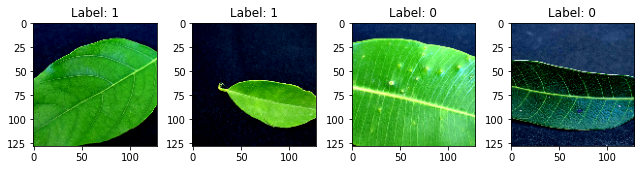

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:07:08] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:07:10] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2657855045924027 samples/sec                   batch loss = 0.5911068320274353 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2624998062290549 samples/sec                   batch loss = 0.5679070353507996 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2655474695260214 samples/sec                   batch loss = 1.178937315940857 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.270091076402145 samples/sec                   batch loss = 0.2773299813270569 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.2668758038218577 samples/sec                   batch loss = 0.3525943160057068 | accuracy = 0.56


Epoch[1] Batch[30] Speed: 1.2728121731381596 samples/sec                   batch loss = 0.7378188371658325 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.2678700533432623 samples/sec                   batch loss = 2.1073858737945557 | accuracy = 0.5357142857142857


Epoch[1] Batch[40] Speed: 1.269672672806303 samples/sec                   batch loss = 0.3989865779876709 | accuracy = 0.525


Epoch[1] Batch[45] Speed: 1.2708940526454096 samples/sec                   batch loss = 0.8055398464202881 | accuracy = 0.5277777777777778


Epoch[1] Batch[50] Speed: 1.2680959274970178 samples/sec                   batch loss = 1.303328514099121 | accuracy = 0.525


Epoch[1] Batch[55] Speed: 1.2708109755691117 samples/sec                   batch loss = 0.9988856315612793 | accuracy = 0.5363636363636364


Epoch[1] Batch[60] Speed: 1.2711320809468187 samples/sec                   batch loss = 0.7849287986755371 | accuracy = 0.5541666666666667


Epoch[1] Batch[65] Speed: 1.26483542687778 samples/sec                   batch loss = 1.2145061492919922 | accuracy = 0.5615384615384615


Epoch[1] Batch[70] Speed: 1.2728739761735808 samples/sec                   batch loss = 0.39464882016181946 | accuracy = 0.5678571428571428


Epoch[1] Batch[75] Speed: 1.2690587830566002 samples/sec                   batch loss = 0.4124291241168976 | accuracy = 0.5866666666666667


Epoch[1] Batch[80] Speed: 1.2711071377160217 samples/sec                   batch loss = 1.3876245021820068 | accuracy = 0.578125


Epoch[1] Batch[85] Speed: 1.2722124161692423 samples/sec                   batch loss = 0.6563950181007385 | accuracy = 0.5705882352941176


Epoch[1] Batch[90] Speed: 1.274444626333195 samples/sec                   batch loss = 0.4400043785572052 | accuracy = 0.5805555555555556


Epoch[1] Batch[95] Speed: 1.2685808175840263 samples/sec                   batch loss = 0.6684874296188354 | accuracy = 0.5815789473684211


Epoch[1] Batch[100] Speed: 1.2738156692419274 samples/sec                   batch loss = 0.2757960855960846 | accuracy = 0.595


Epoch[1] Batch[105] Speed: 1.2742462926799036 samples/sec                   batch loss = 0.4291669428348541 | accuracy = 0.6071428571428571


Epoch[1] Batch[110] Speed: 1.270989561383566 samples/sec                   batch loss = 0.4576193690299988 | accuracy = 0.6113636363636363


Epoch[1] Batch[115] Speed: 1.2718322388682 samples/sec                   batch loss = 0.47460219264030457 | accuracy = 0.6130434782608696


Epoch[1] Batch[120] Speed: 1.2753352263320306 samples/sec                   batch loss = 0.9562631845474243 | accuracy = 0.6145833333333334


Epoch[1] Batch[125] Speed: 1.2701004991838742 samples/sec                   batch loss = 0.5531337857246399 | accuracy = 0.622


Epoch[1] Batch[130] Speed: 1.2749186895490994 samples/sec                   batch loss = 0.7735952734947205 | accuracy = 0.6211538461538462


Epoch[1] Batch[135] Speed: 1.2712391842442627 samples/sec                   batch loss = 0.7332724928855896 | accuracy = 0.6222222222222222


Epoch[1] Batch[140] Speed: 1.2759830559663132 samples/sec                   batch loss = 0.7762305736541748 | accuracy = 0.6214285714285714


Epoch[1] Batch[145] Speed: 1.2722675038231233 samples/sec                   batch loss = 0.6807870268821716 | accuracy = 0.6258620689655172


Epoch[1] Batch[150] Speed: 1.2738960443747778 samples/sec                   batch loss = 0.633398175239563 | accuracy = 0.6316666666666667


Epoch[1] Batch[155] Speed: 1.2754011528559663 samples/sec                   batch loss = 0.5878807306289673 | accuracy = 0.6370967741935484


Epoch[1] Batch[160] Speed: 1.2730966134108306 samples/sec                   batch loss = 0.8941054940223694 | accuracy = 0.6375


Epoch[1] Batch[165] Speed: 1.2711733983360776 samples/sec                   batch loss = 0.8392186760902405 | accuracy = 0.6348484848484849


Epoch[1] Batch[170] Speed: 1.2712256027010829 samples/sec                   batch loss = 0.569368839263916 | accuracy = 0.6338235294117647


Epoch[1] Batch[175] Speed: 1.2759886845590778 samples/sec                   batch loss = 0.5596497058868408 | accuracy = 0.63


Epoch[1] Batch[180] Speed: 1.2722348944430963 samples/sec                   batch loss = 0.5099188685417175 | accuracy = 0.6319444444444444


Epoch[1] Batch[185] Speed: 1.2735497588545563 samples/sec                   batch loss = 0.3454875946044922 | accuracy = 0.6391891891891892


Epoch[1] Batch[190] Speed: 1.2707250219630295 samples/sec                   batch loss = 1.6042587757110596 | accuracy = 0.6407894736842106


Epoch[1] Batch[195] Speed: 1.2758002507462352 samples/sec                   batch loss = 0.6347271203994751 | accuracy = 0.6371794871794871


Epoch[1] Batch[200] Speed: 1.2727733561752381 samples/sec                   batch loss = 0.4273180365562439 | accuracy = 0.6375


Epoch[1] Batch[205] Speed: 1.2731177704145262 samples/sec                   batch loss = 1.432318925857544 | accuracy = 0.6378048780487805


Epoch[1] Batch[210] Speed: 1.2724206358987582 samples/sec                   batch loss = 0.851992130279541 | accuracy = 0.6392857142857142


Epoch[1] Batch[215] Speed: 1.269998106041395 samples/sec                   batch loss = 0.32026103138923645 | accuracy = 0.6430232558139535


Epoch[1] Batch[220] Speed: 1.2739839753604936 samples/sec                   batch loss = 0.5567164421081543 | accuracy = 0.6443181818181818


Epoch[1] Batch[225] Speed: 1.2718785192361852 samples/sec                   batch loss = 0.6081640720367432 | accuracy = 0.6444444444444445


Epoch[1] Batch[230] Speed: 1.274539120295967 samples/sec                   batch loss = 0.42364737391471863 | accuracy = 0.6467391304347826


Epoch[1] Batch[235] Speed: 1.2698829455031417 samples/sec                   batch loss = 0.5287997126579285 | accuracy = 0.6457446808510638


Epoch[1] Batch[240] Speed: 1.26902192247425 samples/sec                   batch loss = 1.0956475734710693 | accuracy = 0.6479166666666667


Epoch[1] Batch[245] Speed: 1.2651094440934696 samples/sec                   batch loss = 0.6772669553756714 | accuracy = 0.6479591836734694


Epoch[1] Batch[250] Speed: 1.276106119974641 samples/sec                   batch loss = 0.4748021960258484 | accuracy = 0.65


Epoch[1] Batch[255] Speed: 1.269382364944585 samples/sec                   batch loss = 0.36751264333724976 | accuracy = 0.6480392156862745


Epoch[1] Batch[260] Speed: 1.2686509401446744 samples/sec                   batch loss = 0.21254576742649078 | accuracy = 0.6519230769230769


Epoch[1] Batch[265] Speed: 1.2733529599857192 samples/sec                   batch loss = 0.4215357005596161 | accuracy = 0.6547169811320754


Epoch[1] Batch[270] Speed: 1.2716211274208298 samples/sec                   batch loss = 0.4262421429157257 | accuracy = 0.6546296296296297


Epoch[1] Batch[275] Speed: 1.273528684162045 samples/sec                   batch loss = 0.4572645127773285 | accuracy = 0.6563636363636364


Epoch[1] Batch[280] Speed: 1.269960133439095 samples/sec                   batch loss = 0.5262413620948792 | accuracy = 0.6544642857142857


Epoch[1] Batch[285] Speed: 1.2716957314036128 samples/sec                   batch loss = 0.49195170402526855 | accuracy = 0.6578947368421053


Epoch[1] Batch[290] Speed: 1.2766215384442128 samples/sec                   batch loss = 0.6543176174163818 | accuracy = 0.6560344827586206


Epoch[1] Batch[295] Speed: 1.2726877161766184 samples/sec                   batch loss = 0.528876781463623 | accuracy = 0.652542372881356


Epoch[1] Batch[300] Speed: 1.275516249755289 samples/sec                   batch loss = 0.569524884223938 | accuracy = 0.6525


Epoch[1] Batch[305] Speed: 1.2720879800114082 samples/sec                   batch loss = 1.0544260740280151 | accuracy = 0.6540983606557377


Epoch[1] Batch[310] Speed: 1.2721463365735732 samples/sec                   batch loss = 0.4507877230644226 | accuracy = 0.657258064516129


Epoch[1] Batch[315] Speed: 1.2752183204640073 samples/sec                   batch loss = 0.41042616963386536 | accuracy = 0.6595238095238095


Epoch[1] Batch[320] Speed: 1.2726614568399077 samples/sec                   batch loss = 0.3087853789329529 | accuracy = 0.65859375


Epoch[1] Batch[325] Speed: 1.2691107178753347 samples/sec                   batch loss = 0.47678083181381226 | accuracy = 0.6607692307692308


Epoch[1] Batch[330] Speed: 1.272008604390174 samples/sec                   batch loss = 0.8558089137077332 | accuracy = 0.6598484848484848


Epoch[1] Batch[335] Speed: 1.2722462785929443 samples/sec                   batch loss = 0.3077138662338257 | accuracy = 0.6626865671641791


Epoch[1] Batch[340] Speed: 1.267270157565646 samples/sec                   batch loss = 0.3350299596786499 | accuracy = 0.6647058823529411


Epoch[1] Batch[345] Speed: 1.2697647306176243 samples/sec                   batch loss = 0.6717169880867004 | accuracy = 0.6652173913043479


Epoch[1] Batch[350] Speed: 1.2733624312294851 samples/sec                   batch loss = 0.5836150050163269 | accuracy = 0.6657142857142857


Epoch[1] Batch[355] Speed: 1.2681969596319895 samples/sec                   batch loss = 0.29304254055023193 | accuracy = 0.6683098591549296


Epoch[1] Batch[360] Speed: 1.269933602031686 samples/sec                   batch loss = 0.5257582664489746 | accuracy = 0.6659722222222222


Epoch[1] Batch[365] Speed: 1.2676973239894027 samples/sec                   batch loss = 0.7804544568061829 | accuracy = 0.6664383561643835


Epoch[1] Batch[370] Speed: 1.267453398815694 samples/sec                   batch loss = 0.707499623298645 | accuracy = 0.6668918918918919


Epoch[1] Batch[375] Speed: 1.265934119001708 samples/sec                   batch loss = 0.33030539751052856 | accuracy = 0.6673333333333333


Epoch[1] Batch[380] Speed: 1.2721835718226606 samples/sec                   batch loss = 0.8203654885292053 | accuracy = 0.6664473684210527


Epoch[1] Batch[385] Speed: 1.269191076423882 samples/sec                   batch loss = 0.6453139185905457 | accuracy = 0.6655844155844156


Epoch[1] Batch[390] Speed: 1.2680983237085226 samples/sec                   batch loss = 0.15385787189006805 | accuracy = 0.6666666666666666


Epoch[1] Batch[395] Speed: 1.2717227220807321 samples/sec                   batch loss = 0.5239264965057373 | accuracy = 0.6658227848101266


Epoch[1] Batch[400] Speed: 1.2731395077945307 samples/sec                   batch loss = 0.5074247717857361 | accuracy = 0.666875


Epoch[1] Batch[405] Speed: 1.263728835620349 samples/sec                   batch loss = 0.5958252549171448 | accuracy = 0.6654320987654321


Epoch[1] Batch[410] Speed: 1.2666117307859996 samples/sec                   batch loss = 0.5794881582260132 | accuracy = 0.6670731707317074


Epoch[1] Batch[415] Speed: 1.2579199878115968 samples/sec                   batch loss = 0.2614310681819916 | accuracy = 0.6692771084337349


Epoch[1] Batch[420] Speed: 1.270280616571448 samples/sec                   batch loss = 0.5888596177101135 | accuracy = 0.6696428571428571


Epoch[1] Batch[425] Speed: 1.2721850188322967 samples/sec                   batch loss = 0.5527793765068054 | accuracy = 0.6688235294117647


Epoch[1] Batch[430] Speed: 1.2748543628530595 samples/sec                   batch loss = 0.8085198402404785 | accuracy = 0.666860465116279


Epoch[1] Batch[435] Speed: 1.2749278934475843 samples/sec                   batch loss = 0.4125461280345917 | accuracy = 0.6701149425287356


Epoch[1] Batch[440] Speed: 1.2730016570736877 samples/sec                   batch loss = 0.8647785186767578 | accuracy = 0.6710227272727273


Epoch[1] Batch[445] Speed: 1.2751349678442416 samples/sec                   batch loss = 0.3379264175891876 | accuracy = 0.6724719101123595


Epoch[1] Batch[450] Speed: 1.2669444942429038 samples/sec                   batch loss = 0.4156769812107086 | accuracy = 0.6727777777777778


Epoch[1] Batch[455] Speed: 1.2636498334838717 samples/sec                   batch loss = 0.3376471698284149 | accuracy = 0.6741758241758242


Epoch[1] Batch[460] Speed: 1.2641763835270527 samples/sec                   batch loss = 0.16440726816654205 | accuracy = 0.6760869565217391


Epoch[1] Batch[465] Speed: 1.275881264643129 samples/sec                   batch loss = 0.5344234108924866 | accuracy = 0.6768817204301075


Epoch[1] Batch[470] Speed: 1.2635958702329282 samples/sec                   batch loss = 0.2103683203458786 | accuracy = 0.6776595744680851


Epoch[1] Batch[475] Speed: 1.270801253469435 samples/sec                   batch loss = 0.49097076058387756 | accuracy = 0.6768421052631579


Epoch[1] Batch[480] Speed: 1.271387829602123 samples/sec                   batch loss = 0.8256570100784302 | accuracy = 0.6760416666666667


Epoch[1] Batch[485] Speed: 1.2703814199738914 samples/sec                   batch loss = 0.9168714284896851 | accuracy = 0.6752577319587629


Epoch[1] Batch[490] Speed: 1.2702652281466011 samples/sec                   batch loss = 0.43690183758735657 | accuracy = 0.6760204081632653


Epoch[1] Batch[495] Speed: 1.2674725493397208 samples/sec                   batch loss = 0.3497859835624695 | accuracy = 0.6757575757575758


Epoch[1] Batch[500] Speed: 1.273916067195265 samples/sec                   batch loss = 0.4299776554107666 | accuracy = 0.6765


Epoch[1] Batch[505] Speed: 1.2694781268867041 samples/sec                   batch loss = 0.6480960249900818 | accuracy = 0.6767326732673268


Epoch[1] Batch[510] Speed: 1.274463891895374 samples/sec                   batch loss = 0.9851502776145935 | accuracy = 0.6779411764705883


Epoch[1] Batch[515] Speed: 1.2706700678005125 samples/sec                   batch loss = 0.40436387062072754 | accuracy = 0.679126213592233


Epoch[1] Batch[520] Speed: 1.2653755632628727 samples/sec                   batch loss = 1.0985238552093506 | accuracy = 0.6798076923076923


Epoch[1] Batch[525] Speed: 1.2689059791876989 samples/sec                   batch loss = 0.68031907081604 | accuracy = 0.6785714285714286


Epoch[1] Batch[530] Speed: 1.2668717859498275 samples/sec                   batch loss = 0.4692252278327942 | accuracy = 0.6792452830188679


Epoch[1] Batch[535] Speed: 1.2786556127167625 samples/sec                   batch loss = 0.7755463123321533 | accuracy = 0.6794392523364486


Epoch[1] Batch[540] Speed: 1.273702136097842 samples/sec                   batch loss = 0.3085575997829437 | accuracy = 0.6800925925925926


Epoch[1] Batch[545] Speed: 1.2647323554128822 samples/sec                   batch loss = 0.7177733182907104 | accuracy = 0.6802752293577982


Epoch[1] Batch[550] Speed: 1.2742143559888974 samples/sec                   batch loss = 0.5861656069755554 | accuracy = 0.6804545454545454


Epoch[1] Batch[555] Speed: 1.2677998254710152 samples/sec                   batch loss = 0.23960134387016296 | accuracy = 0.681981981981982


Epoch[1] Batch[560] Speed: 1.2641196130941124 samples/sec                   batch loss = 2.392012357711792 | accuracy = 0.68125


Epoch[1] Batch[565] Speed: 1.2692477271551212 samples/sec                   batch loss = 0.39238440990448 | accuracy = 0.6827433628318584


Epoch[1] Batch[570] Speed: 1.2686737724187203 samples/sec                   batch loss = 0.44177061319351196 | accuracy = 0.6837719298245614


Epoch[1] Batch[575] Speed: 1.2693858224964927 samples/sec                   batch loss = 0.444360613822937 | accuracy = 0.6843478260869565


Epoch[1] Batch[580] Speed: 1.2633551379834576 samples/sec                   batch loss = 0.15640591084957123 | accuracy = 0.6849137931034482


Epoch[1] Batch[585] Speed: 1.2699506166111065 samples/sec                   batch loss = 0.5262234210968018 | accuracy = 0.6858974358974359


Epoch[1] Batch[590] Speed: 1.2684940144819823 samples/sec                   batch loss = 0.42459601163864136 | accuracy = 0.6877118644067797


Epoch[1] Batch[595] Speed: 1.2738647055714938 samples/sec                   batch loss = 0.6176117658615112 | accuracy = 0.688655462184874


Epoch[1] Batch[600] Speed: 1.275268240331114 samples/sec                   batch loss = 0.7855883836746216 | accuracy = 0.6891666666666667


Epoch[1] Batch[605] Speed: 1.2775468978633557 samples/sec                   batch loss = 0.6207719445228577 | accuracy = 0.6892561983471074


Epoch[1] Batch[610] Speed: 1.2725874152077585 samples/sec                   batch loss = 0.5388277769088745 | accuracy = 0.6901639344262295


Epoch[1] Batch[615] Speed: 1.2701648278270097 samples/sec                   batch loss = 0.42830890417099 | accuracy = 0.6898373983739837


Epoch[1] Batch[620] Speed: 1.2746253970000154 samples/sec                   batch loss = 0.802651047706604 | accuracy = 0.6907258064516129


Epoch[1] Batch[625] Speed: 1.2717054671943326 samples/sec                   batch loss = 0.27262869477272034 | accuracy = 0.6916


Epoch[1] Batch[630] Speed: 1.2693967715351293 samples/sec                   batch loss = 0.43914681673049927 | accuracy = 0.692063492063492


Epoch[1] Batch[635] Speed: 1.2712947656398235 samples/sec                   batch loss = 0.500540554523468 | accuracy = 0.6913385826771653


Epoch[1] Batch[640] Speed: 1.2683717429737518 samples/sec                   batch loss = 1.2435925006866455 | accuracy = 0.691015625


Epoch[1] Batch[645] Speed: 1.2699262003513088 samples/sec                   batch loss = 0.3196769952774048 | accuracy = 0.6914728682170542


Epoch[1] Batch[650] Speed: 1.2700634819170633 samples/sec                   batch loss = 0.5400841236114502 | accuracy = 0.6923076923076923


Epoch[1] Batch[655] Speed: 1.2753113781212686 samples/sec                   batch loss = 0.18102297186851501 | accuracy = 0.6938931297709924


Epoch[1] Batch[660] Speed: 1.2713853245965523 samples/sec                   batch loss = 0.3935477137565613 | accuracy = 0.6935606060606061


Epoch[1] Batch[665] Speed: 1.2682952273872041 samples/sec                   batch loss = 0.324557363986969 | accuracy = 0.6943609022556391


Epoch[1] Batch[670] Speed: 1.2624466061263953 samples/sec                   batch loss = 0.48923349380493164 | accuracy = 0.6947761194029851


Epoch[1] Batch[675] Speed: 1.2666329596800368 samples/sec                   batch loss = 0.34306034445762634 | accuracy = 0.6948148148148148


Epoch[1] Batch[680] Speed: 1.2692721173322827 samples/sec                   batch loss = 0.10712402313947678 | accuracy = 0.6963235294117647


Epoch[1] Batch[685] Speed: 1.2662034521316805 samples/sec                   batch loss = 0.2766058146953583 | accuracy = 0.6970802919708029


Epoch[1] Batch[690] Speed: 1.2705665243618167 samples/sec                   batch loss = 0.37258121371269226 | accuracy = 0.6985507246376812


Epoch[1] Batch[695] Speed: 1.2717349646583969 samples/sec                   batch loss = 0.6229908466339111 | accuracy = 0.6996402877697842


Epoch[1] Batch[700] Speed: 1.2687090777207966 samples/sec                   batch loss = 0.43033796548843384 | accuracy = 0.7


Epoch[1] Batch[705] Speed: 1.2656879117987496 samples/sec                   batch loss = 0.38414624333381653 | accuracy = 0.699645390070922


Epoch[1] Batch[710] Speed: 1.2779829686224446 samples/sec                   batch loss = 0.8161081075668335 | accuracy = 0.6996478873239437


Epoch[1] Batch[715] Speed: 1.2772355731221083 samples/sec                   batch loss = 0.5779329538345337 | accuracy = 0.6993006993006993


Epoch[1] Batch[720] Speed: 1.270785756172552 samples/sec                   batch loss = 0.4436931014060974 | accuracy = 0.7


Epoch[1] Batch[725] Speed: 1.2672290935195023 samples/sec                   batch loss = 0.38687655329704285 | accuracy = 0.7013793103448276


Epoch[1] Batch[730] Speed: 1.2717344826626928 samples/sec                   batch loss = 0.38034090399742126 | accuracy = 0.7017123287671233


Epoch[1] Batch[735] Speed: 1.272037537248149 samples/sec                   batch loss = 0.7116070985794067 | accuracy = 0.7017006802721089


Epoch[1] Batch[740] Speed: 1.2620076864357848 samples/sec                   batch loss = 0.8055883049964905 | accuracy = 0.7010135135135135


Epoch[1] Batch[745] Speed: 1.2677433997074639 samples/sec                   batch loss = 0.9257954359054565 | accuracy = 0.702013422818792


Epoch[1] Batch[750] Speed: 1.2680652567895454 samples/sec                   batch loss = 0.9238945841789246 | accuracy = 0.7023333333333334


Epoch[1] Batch[755] Speed: 1.2737076478869647 samples/sec                   batch loss = 0.6616058945655823 | accuracy = 0.7013245033112583


Epoch[1] Batch[760] Speed: 1.265964495650147 samples/sec                   batch loss = 0.4207386076450348 | accuracy = 0.7009868421052632


Epoch[1] Batch[765] Speed: 1.2599302432534485 samples/sec                   batch loss = 0.38967597484588623 | accuracy = 0.7016339869281045


Epoch[1] Batch[770] Speed: 1.2730268679040497 samples/sec                   batch loss = 0.5120458602905273 | accuracy = 0.700974025974026


Epoch[1] Batch[775] Speed: 1.2653075199944974 samples/sec                   batch loss = 0.504342257976532 | accuracy = 0.7016129032258065


Epoch[1] Batch[780] Speed: 1.2692941077049935 samples/sec                   batch loss = 0.27001115679740906 | accuracy = 0.7012820512820512


Epoch[1] Batch[785] Speed: 1.2650780591447484 samples/sec                   batch loss = 0.4238831698894501 | accuracy = 0.7012738853503184


[Epoch 1] training: accuracy=0.7014593908629442
[Epoch 1] time cost: 647.8117389678955
[Epoch 1] validation: validation accuracy=0.7744444444444445


Epoch[2] Batch[5] Speed: 1.261689276185318 samples/sec                   batch loss = 0.7035741209983826 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2648672765926874 samples/sec                   batch loss = 0.4800150692462921 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.264773925231165 samples/sec                   batch loss = 0.4250739514827728 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2671216121246955 samples/sec                   batch loss = 0.46653151512145996 | accuracy = 0.75


Epoch[2] Batch[25] Speed: 1.2665090388869962 samples/sec                   batch loss = 0.8041102886199951 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2664176437175299 samples/sec                   batch loss = 0.3468298316001892 | accuracy = 0.775


Epoch[2] Batch[35] Speed: 1.2651094440934696 samples/sec                   batch loss = 0.454900860786438 | accuracy = 0.7785714285714286


Epoch[2] Batch[40] Speed: 1.2617227705050813 samples/sec                   batch loss = 0.3904493451118469 | accuracy = 0.75625


Epoch[2] Batch[45] Speed: 1.267298109440966 samples/sec                   batch loss = 1.0905884504318237 | accuracy = 0.7666666666666667


Epoch[2] Batch[50] Speed: 1.261485786606001 samples/sec                   batch loss = 0.27015358209609985 | accuracy = 0.765


Epoch[2] Batch[55] Speed: 1.2636203291953318 samples/sec                   batch loss = 0.40620851516723633 | accuracy = 0.75


Epoch[2] Batch[60] Speed: 1.2675284721820859 samples/sec                   batch loss = 0.35995346307754517 | accuracy = 0.75


Epoch[2] Batch[65] Speed: 1.2618365506103362 samples/sec                   batch loss = 0.3123835623264313 | accuracy = 0.7653846153846153


Epoch[2] Batch[70] Speed: 1.2600181493750797 samples/sec                   batch loss = 0.20744039118289948 | accuracy = 0.7714285714285715


Epoch[2] Batch[75] Speed: 1.2663249236059717 samples/sec                   batch loss = 0.5297006964683533 | accuracy = 0.7633333333333333


Epoch[2] Batch[80] Speed: 1.2711036707807357 samples/sec                   batch loss = 0.4004414677619934 | accuracy = 0.765625


Epoch[2] Batch[85] Speed: 1.2639300025184859 samples/sec                   batch loss = 0.5647957921028137 | accuracy = 0.7558823529411764


Epoch[2] Batch[90] Speed: 1.2609148485711645 samples/sec                   batch loss = 0.23345841467380524 | accuracy = 0.7638888888888888


Epoch[2] Batch[95] Speed: 1.2595088616797505 samples/sec                   batch loss = 0.27106350660324097 | accuracy = 0.7710526315789473


Epoch[2] Batch[100] Speed: 1.2684065519911465 samples/sec                   batch loss = 0.4997231960296631 | accuracy = 0.7675


Epoch[2] Batch[105] Speed: 1.2647100461326393 samples/sec                   batch loss = 0.33915984630584717 | accuracy = 0.7666666666666667


Epoch[2] Batch[110] Speed: 1.2695885063650387 samples/sec                   batch loss = 1.0654023885726929 | accuracy = 0.7636363636363637


Epoch[2] Batch[115] Speed: 1.2730917831432889 samples/sec                   batch loss = 0.8240002393722534 | accuracy = 0.7608695652173914


Epoch[2] Batch[120] Speed: 1.268944656588001 samples/sec                   batch loss = 0.4375655949115753 | accuracy = 0.75625


Epoch[2] Batch[125] Speed: 1.2644138077606288 samples/sec                   batch loss = 0.9692724347114563 | accuracy = 0.754


Epoch[2] Batch[130] Speed: 1.2616011367423572 samples/sec                   batch loss = 0.26982390880584717 | accuracy = 0.7557692307692307


Epoch[2] Batch[135] Speed: 1.265033798520268 samples/sec                   batch loss = 0.09876694530248642 | accuracy = 0.762962962962963


Epoch[2] Batch[140] Speed: 1.2649358447456567 samples/sec                   batch loss = 0.9129205942153931 | accuracy = 0.7625


Epoch[2] Batch[145] Speed: 1.2696941966103379 samples/sec                   batch loss = 0.5887007117271423 | accuracy = 0.7655172413793103


Epoch[2] Batch[150] Speed: 1.2701830025703897 samples/sec                   batch loss = 0.5887527465820312 | accuracy = 0.7633333333333333


Epoch[2] Batch[155] Speed: 1.2673687604308046 samples/sec                   batch loss = 0.7188934683799744 | accuracy = 0.7564516129032258


Epoch[2] Batch[160] Speed: 1.2635188830266344 samples/sec                   batch loss = 0.7454845309257507 | accuracy = 0.753125


Epoch[2] Batch[165] Speed: 1.266570900634538 samples/sec                   batch loss = 0.22171804308891296 | accuracy = 0.7545454545454545


Epoch[2] Batch[170] Speed: 1.2759943132014997 samples/sec                   batch loss = 0.41891252994537354 | accuracy = 0.7558823529411764


Epoch[2] Batch[175] Speed: 1.27079037644512 samples/sec                   batch loss = 0.5763784646987915 | accuracy = 0.7557142857142857


Epoch[2] Batch[180] Speed: 1.2681962885874765 samples/sec                   batch loss = 0.3118882477283478 | accuracy = 0.7555555555555555


Epoch[2] Batch[185] Speed: 1.2686293557673498 samples/sec                   batch loss = 0.34882164001464844 | accuracy = 0.7554054054054054


Epoch[2] Batch[190] Speed: 1.276956083992899 samples/sec                   batch loss = 0.5209944844245911 | accuracy = 0.7578947368421053


Epoch[2] Batch[195] Speed: 1.2683977296902857 samples/sec                   batch loss = 0.794884204864502 | accuracy = 0.7564102564102564


Epoch[2] Batch[200] Speed: 1.2680593145115453 samples/sec                   batch loss = 0.3698940575122833 | accuracy = 0.75875


Epoch[2] Batch[205] Speed: 1.2681784582362545 samples/sec                   batch loss = 0.4869421422481537 | accuracy = 0.7585365853658537


Epoch[2] Batch[210] Speed: 1.2696718080258542 samples/sec                   batch loss = 0.572446882724762 | accuracy = 0.7571428571428571


Epoch[2] Batch[215] Speed: 1.26846687296661 samples/sec                   batch loss = 0.4629859924316406 | accuracy = 0.7581395348837209


Epoch[2] Batch[220] Speed: 1.2655878518406987 samples/sec                   batch loss = 0.6800657510757446 | accuracy = 0.7556818181818182


Epoch[2] Batch[225] Speed: 1.2696909295573917 samples/sec                   batch loss = 0.5291290879249573 | accuracy = 0.7577777777777778


Epoch[2] Batch[230] Speed: 1.2624360616384729 samples/sec                   batch loss = 0.385370671749115 | accuracy = 0.7597826086956522


Epoch[2] Batch[235] Speed: 1.2614244205826748 samples/sec                   batch loss = 0.24689984321594238 | accuracy = 0.7606382978723404


Epoch[2] Batch[240] Speed: 1.2606954091800768 samples/sec                   batch loss = 0.3220689296722412 | accuracy = 0.759375


Epoch[2] Batch[245] Speed: 1.2683354975977383 samples/sec                   batch loss = 0.4176843762397766 | accuracy = 0.763265306122449


Epoch[2] Batch[250] Speed: 1.2719815051402872 samples/sec                   batch loss = 0.6891176104545593 | accuracy = 0.762


Epoch[2] Batch[255] Speed: 1.2671804710040937 samples/sec                   batch loss = 0.3852715790271759 | accuracy = 0.7627450980392156


Epoch[2] Batch[260] Speed: 1.26696870030259 samples/sec                   batch loss = 0.257752001285553 | accuracy = 0.7644230769230769


Epoch[2] Batch[265] Speed: 1.2712527660776511 samples/sec                   batch loss = 0.4894387423992157 | accuracy = 0.7641509433962265


Epoch[2] Batch[270] Speed: 1.2667075533288943 samples/sec                   batch loss = 0.20348897576332092 | accuracy = 0.7657407407407407


Epoch[2] Batch[275] Speed: 1.265724483460241 samples/sec                   batch loss = 0.33317872881889343 | accuracy = 0.7672727272727272


Epoch[2] Batch[280] Speed: 1.2672482372658185 samples/sec                   batch loss = 0.3742362856864929 | accuracy = 0.7669642857142858


Epoch[2] Batch[285] Speed: 1.269534322917187 samples/sec                   batch loss = 0.6357599496841431 | accuracy = 0.7675438596491229


Epoch[2] Batch[290] Speed: 1.264416571248169 samples/sec                   batch loss = 0.3816951811313629 | accuracy = 0.7689655172413793


Epoch[2] Batch[295] Speed: 1.2635706508935636 samples/sec                   batch loss = 0.1269320249557495 | accuracy = 0.7686440677966102


Epoch[2] Batch[300] Speed: 1.2676488570982134 samples/sec                   batch loss = 0.7821827530860901 | accuracy = 0.7691666666666667


Epoch[2] Batch[305] Speed: 1.2643957977411793 samples/sec                   batch loss = 0.19273331761360168 | accuracy = 0.7704918032786885


Epoch[2] Batch[310] Speed: 1.2652367169577394 samples/sec                   batch loss = 0.22821886837482452 | accuracy = 0.7709677419354839


Epoch[2] Batch[315] Speed: 1.2658060372821367 samples/sec                   batch loss = 0.5128945708274841 | accuracy = 0.7722222222222223


Epoch[2] Batch[320] Speed: 1.2647965228155365 samples/sec                   batch loss = 0.3898822069168091 | accuracy = 0.771875


Epoch[2] Batch[325] Speed: 1.2659211281757123 samples/sec                   batch loss = 0.40282002091407776 | accuracy = 0.7723076923076924


Epoch[2] Batch[330] Speed: 1.269384573933909 samples/sec                   batch loss = 0.4438606798648834 | accuracy = 0.771969696969697


Epoch[2] Batch[335] Speed: 1.2723458503494223 samples/sec                   batch loss = 0.45169562101364136 | accuracy = 0.7708955223880597


Epoch[2] Batch[340] Speed: 1.2658305818829887 samples/sec                   batch loss = 0.24511320888996124 | accuracy = 0.7713235294117647


Epoch[2] Batch[345] Speed: 1.262551585634354 samples/sec                   batch loss = 0.35078543424606323 | accuracy = 0.7710144927536232


Epoch[2] Batch[350] Speed: 1.2642226799698828 samples/sec                   batch loss = 0.8116036057472229 | accuracy = 0.7714285714285715


Epoch[2] Batch[355] Speed: 1.2652943511748826 samples/sec                   batch loss = 0.5100260376930237 | accuracy = 0.7711267605633803


Epoch[2] Batch[360] Speed: 1.2621915929056071 samples/sec                   batch loss = 0.3055288791656494 | accuracy = 0.7701388888888889


Epoch[2] Batch[365] Speed: 1.2670836199471756 samples/sec                   batch loss = 0.32471519708633423 | accuracy = 0.7691780821917809


Epoch[2] Batch[370] Speed: 1.2636641102471544 samples/sec                   batch loss = 0.6070446968078613 | accuracy = 0.7675675675675676


Epoch[2] Batch[375] Speed: 1.26643026234931 samples/sec                   batch loss = 0.2466125339269638 | accuracy = 0.77


Epoch[2] Batch[380] Speed: 1.2651602929234056 samples/sec                   batch loss = 0.32660773396492004 | accuracy = 0.7710526315789473


Epoch[2] Batch[385] Speed: 1.2626531616121053 samples/sec                   batch loss = 0.1736295521259308 | accuracy = 0.7694805194805194


Epoch[2] Batch[390] Speed: 1.264295370321039 samples/sec                   batch loss = 0.5542284250259399 | accuracy = 0.7698717948717949


Epoch[2] Batch[395] Speed: 1.2634223054234586 samples/sec                   batch loss = 0.23678286373615265 | accuracy = 0.770253164556962


Epoch[2] Batch[400] Speed: 1.266843661559186 samples/sec                   batch loss = 0.531093955039978 | accuracy = 0.771875


Epoch[2] Batch[405] Speed: 1.2626142016342654 samples/sec                   batch loss = 0.178662970662117 | accuracy = 0.7716049382716049


Epoch[2] Batch[410] Speed: 1.2616582504559042 samples/sec                   batch loss = 0.41425999999046326 | accuracy = 0.7701219512195122


Epoch[2] Batch[415] Speed: 1.2641267567439884 samples/sec                   batch loss = 0.7195397615432739 | accuracy = 0.7698795180722892


Epoch[2] Batch[420] Speed: 1.2656737802345748 samples/sec                   batch loss = 0.9813004732131958 | accuracy = 0.7696428571428572


Epoch[2] Batch[425] Speed: 1.263527161793937 samples/sec                   batch loss = 0.3763796389102936 | accuracy = 0.768235294117647


Epoch[2] Batch[430] Speed: 1.2604153464730272 samples/sec                   batch loss = 0.20221056044101715 | accuracy = 0.7680232558139535


Epoch[2] Batch[435] Speed: 1.2612966807958343 samples/sec                   batch loss = 0.5281734466552734 | accuracy = 0.7672413793103449


Epoch[2] Batch[440] Speed: 1.2603090177528733 samples/sec                   batch loss = 0.3907981812953949 | accuracy = 0.7670454545454546


Epoch[2] Batch[445] Speed: 1.263886203040776 samples/sec                   batch loss = 0.26440343260765076 | accuracy = 0.7679775280898876


Epoch[2] Batch[450] Speed: 1.2649666503832362 samples/sec                   batch loss = 0.41285327076911926 | accuracy = 0.7677777777777778


Epoch[2] Batch[455] Speed: 1.266435902576651 samples/sec                   batch loss = 0.35144898295402527 | accuracy = 0.7675824175824176


Epoch[2] Batch[460] Speed: 1.2750437770540521 samples/sec                   batch loss = 0.3147989511489868 | accuracy = 0.7684782608695652


Epoch[2] Batch[465] Speed: 1.2609537037454586 samples/sec                   batch loss = 0.5783140063285828 | accuracy = 0.7666666666666667


Epoch[2] Batch[470] Speed: 1.2672639355694055 samples/sec                   batch loss = 0.25272679328918457 | accuracy = 0.7670212765957447


Epoch[2] Batch[475] Speed: 1.2709904279600053 samples/sec                   batch loss = 0.2587829828262329 | accuracy = 0.7668421052631579


Epoch[2] Batch[480] Speed: 1.2692161365473484 samples/sec                   batch loss = 0.24465018510818481 | accuracy = 0.7671875


Epoch[2] Batch[485] Speed: 1.2727602246043528 samples/sec                   batch loss = 0.5167892575263977 | accuracy = 0.7664948453608248


Epoch[2] Batch[490] Speed: 1.2686878751161992 samples/sec                   batch loss = 0.5568003058433533 | accuracy = 0.7658163265306123


Epoch[2] Batch[495] Speed: 1.2648299916076138 samples/sec                   batch loss = 0.397962361574173 | accuracy = 0.7661616161616162


Epoch[2] Batch[500] Speed: 1.271557807652471 samples/sec                   batch loss = 0.3111898899078369 | accuracy = 0.7675


Epoch[2] Batch[505] Speed: 1.2694038789069209 samples/sec                   batch loss = 0.1981041133403778 | accuracy = 0.7673267326732673


Epoch[2] Batch[510] Speed: 1.2712168374620514 samples/sec                   batch loss = 1.2232282161712646 | accuracy = 0.7671568627450981


Epoch[2] Batch[515] Speed: 1.2650240692292607 samples/sec                   batch loss = 0.5059439539909363 | accuracy = 0.7669902912621359


Epoch[2] Batch[520] Speed: 1.268744289041592 samples/sec                   batch loss = 0.35573774576187134 | accuracy = 0.7668269230769231


Epoch[2] Batch[525] Speed: 1.2678221480848892 samples/sec                   batch loss = 0.319307804107666 | accuracy = 0.768095238095238


Epoch[2] Batch[530] Speed: 1.2684779979702496 samples/sec                   batch loss = 0.2850187420845032 | accuracy = 0.7674528301886793


Epoch[2] Batch[535] Speed: 1.272683950984586 samples/sec                   batch loss = 0.3788478672504425 | accuracy = 0.766822429906542


Epoch[2] Batch[540] Speed: 1.26848547868587 samples/sec                   batch loss = 0.8338594436645508 | accuracy = 0.7662037037037037


Epoch[2] Batch[545] Speed: 1.266239958024501 samples/sec                   batch loss = 0.3967280387878418 | accuracy = 0.7665137614678899


Epoch[2] Batch[550] Speed: 1.267408493106435 samples/sec                   batch loss = 0.35327252745628357 | accuracy = 0.7681818181818182


Epoch[2] Batch[555] Speed: 1.2648998908371596 samples/sec                   batch loss = 0.3922065794467926 | accuracy = 0.7684684684684685


Epoch[2] Batch[560] Speed: 1.2666265526865923 samples/sec                   batch loss = 0.7314468622207642 | accuracy = 0.7678571428571429


Epoch[2] Batch[565] Speed: 1.2647768809874376 samples/sec                   batch loss = 0.6457695364952087 | accuracy = 0.7676991150442478


Epoch[2] Batch[570] Speed: 1.2602536354547893 samples/sec                   batch loss = 1.500597357749939 | accuracy = 0.7679824561403509


Epoch[2] Batch[575] Speed: 1.26756103227415 samples/sec                   batch loss = 0.6140125393867493 | accuracy = 0.7682608695652174


Epoch[2] Batch[580] Speed: 1.2630608651686146 samples/sec                   batch loss = 0.5881308317184448 | accuracy = 0.7672413793103449


Epoch[2] Batch[585] Speed: 1.2678122800513436 samples/sec                   batch loss = 0.1301107406616211 | accuracy = 0.7675213675213676


Epoch[2] Batch[590] Speed: 1.2628641574003625 samples/sec                   batch loss = 0.48235437273979187 | accuracy = 0.7673728813559322


Epoch[2] Batch[595] Speed: 1.2582860410272318 samples/sec                   batch loss = 0.295855849981308 | accuracy = 0.7672268907563026


Epoch[2] Batch[600] Speed: 1.260264616856921 samples/sec                   batch loss = 0.49775731563568115 | accuracy = 0.7683333333333333


Epoch[2] Batch[605] Speed: 1.2695410475618119 samples/sec                   batch loss = 0.28736838698387146 | accuracy = 0.7698347107438016


Epoch[2] Batch[610] Speed: 1.2588561116801165 samples/sec                   batch loss = 0.9648101925849915 | accuracy = 0.7700819672131147


Epoch[2] Batch[615] Speed: 1.2641015162091036 samples/sec                   batch loss = 0.6766472458839417 | accuracy = 0.7699186991869919


Epoch[2] Batch[620] Speed: 1.2665679364871578 samples/sec                   batch loss = 0.9203146696090698 | accuracy = 0.7689516129032258


Epoch[2] Batch[625] Speed: 1.2638748728005456 samples/sec                   batch loss = 0.3178975284099579 | accuracy = 0.77


Epoch[2] Batch[630] Speed: 1.2659594327741714 samples/sec                   batch loss = 1.4502345323562622 | accuracy = 0.7686507936507937


Epoch[2] Batch[635] Speed: 1.2662601231766848 samples/sec                   batch loss = 0.6312938332557678 | accuracy = 0.7665354330708661


Epoch[2] Batch[640] Speed: 1.2664213719234743 samples/sec                   batch loss = 0.585249662399292 | accuracy = 0.766015625


Epoch[2] Batch[645] Speed: 1.267221053318525 samples/sec                   batch loss = 0.4609111249446869 | accuracy = 0.7662790697674419


Epoch[2] Batch[650] Speed: 1.2660507618166361 samples/sec                   batch loss = 0.5952690243721008 | accuracy = 0.7638461538461538


Epoch[2] Batch[655] Speed: 1.2664620968332438 samples/sec                   batch loss = 0.274019718170166 | accuracy = 0.7637404580152671


Epoch[2] Batch[660] Speed: 1.2689819925929982 samples/sec                   batch loss = 0.7822456955909729 | accuracy = 0.7636363636363637


Epoch[2] Batch[665] Speed: 1.278244111234834 samples/sec                   batch loss = 0.43230190873146057 | accuracy = 0.7635338345864662


Epoch[2] Batch[670] Speed: 1.2655463239660325 samples/sec                   batch loss = 0.7720329165458679 | accuracy = 0.7626865671641792


Epoch[2] Batch[675] Speed: 1.2676967492614706 samples/sec                   batch loss = 0.42465218901634216 | accuracy = 0.7637037037037037


Epoch[2] Batch[680] Speed: 1.2643755013500466 samples/sec                   batch loss = 0.12904676795005798 | accuracy = 0.7643382352941176


Epoch[2] Batch[685] Speed: 1.2646836383010656 samples/sec                   batch loss = 0.928924024105072 | accuracy = 0.7635036496350365


Epoch[2] Batch[690] Speed: 1.2727432312089586 samples/sec                   batch loss = 0.48522400856018066 | accuracy = 0.763768115942029


Epoch[2] Batch[695] Speed: 1.2720079293058681 samples/sec                   batch loss = 0.4805709421634674 | accuracy = 0.7643884892086331


Epoch[2] Batch[700] Speed: 1.2613950201213862 samples/sec                   batch loss = 0.5771573781967163 | accuracy = 0.7657142857142857


Epoch[2] Batch[705] Speed: 1.268069090546843 samples/sec                   batch loss = 0.4622857868671417 | accuracy = 0.7659574468085106


Epoch[2] Batch[710] Speed: 1.2628714769881013 samples/sec                   batch loss = 0.4944747984409332 | accuracy = 0.7665492957746479


Epoch[2] Batch[715] Speed: 1.2652222138094698 samples/sec                   batch loss = 0.6877428889274597 | accuracy = 0.7664335664335664


Epoch[2] Batch[720] Speed: 1.2607152086495508 samples/sec                   batch loss = 0.2930486500263214 | accuracy = 0.7666666666666667


Epoch[2] Batch[725] Speed: 1.2659837922657287 samples/sec                   batch loss = 0.5555467009544373 | accuracy = 0.766896551724138


Epoch[2] Batch[730] Speed: 1.2692656836118552 samples/sec                   batch loss = 0.15564914047718048 | accuracy = 0.7684931506849315


Epoch[2] Batch[735] Speed: 1.2629486705334765 samples/sec                   batch loss = 0.26411691308021545 | accuracy = 0.7680272108843538


Epoch[2] Batch[740] Speed: 1.2685432174339162 samples/sec                   batch loss = 0.7838401198387146 | accuracy = 0.7679054054054054


Epoch[2] Batch[745] Speed: 1.2675249289788717 samples/sec                   batch loss = 0.5140805244445801 | accuracy = 0.7684563758389261


Epoch[2] Batch[750] Speed: 1.2652675372518338 samples/sec                   batch loss = 0.5982525944709778 | accuracy = 0.7676666666666667


Epoch[2] Batch[755] Speed: 1.264557811074616 samples/sec                   batch loss = 0.12111486494541168 | accuracy = 0.766887417218543


Epoch[2] Batch[760] Speed: 1.2638172726199626 samples/sec                   batch loss = 0.4475500285625458 | accuracy = 0.7664473684210527


Epoch[2] Batch[765] Speed: 1.2604822016750066 samples/sec                   batch loss = 0.4830128848552704 | accuracy = 0.7673202614379085


Epoch[2] Batch[770] Speed: 1.2633871034665098 samples/sec                   batch loss = 0.6499415636062622 | accuracy = 0.7659090909090909


Epoch[2] Batch[775] Speed: 1.2622712675336605 samples/sec                   batch loss = 0.3376615047454834 | accuracy = 0.765483870967742


Epoch[2] Batch[780] Speed: 1.2604723528712172 samples/sec                   batch loss = 0.21128328144550323 | accuracy = 0.7663461538461539


Epoch[2] Batch[785] Speed: 1.2687110924848004 samples/sec                   batch loss = 0.2840242087841034 | accuracy = 0.7662420382165606


[Epoch 2] training: accuracy=0.7658629441624365
[Epoch 2] time cost: 640.0893371105194
[Epoch 2] validation: validation accuracy=0.8244444444444444


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8222222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)